***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying bottom-up approach. (Fine-to-Coarse)
- Changing the Secondary Capsule Dimension:
    - 16D>12D>8D (Fine>Medium>Coarse)
    - Just use Hinge Loss (MarginLoss) for each level.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_1_3')

FOLDER CREATED =  ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_WO_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2823 - prediction_coarse_accuracy: 0.8620 - prediction_medium_accuracy: 0.5733 - prediction_fine_accuracy: 0.4831
  • Coarse Accuracy = 86.20% | Val_Accuracy = 92.65% | LossWeight = 0.19 
  • Medium Accuracy = 57.33% | Val_Accuracy = 71.34% | LossWeight = 0.42 
  • Fine   Accuracy = 48.31% | Val_Accuracy = 62.82% | LossWeight = 0.38 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.62820, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_WO_C_loss\epoch-best.h5
781/781 [==============================] - 58s 64ms/step - loss: 0.2823 - prediction_coarse_accuracy: 0.8620 - prediction_medium_accuracy: 0.5733 - prediction_fine_accuracy: 0.4831 - val_loss: 0.1486 - val_prediction_coarse_accuracy: 0.9265 - val_prediction_medium_accuracy: 0.7134 - val_prediction_fine_accuracy: 0.6282 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1421 - prediction_coarse_accurac

Epoch 18/100
780/781 [============================>.] - ETA: 0s - loss: 0.0624 - prediction_coarse_accuracy: 0.9819 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.9345
  • Coarse Accuracy = 98.19% | Val_Accuracy = 98.40% | LossWeight = 0.21 
  • Medium Accuracy = 95.17% | Val_Accuracy = 92.01% | LossWeight = 0.39 
  • Fine   Accuracy = 93.45% | Val_Accuracy = 88.81% | LossWeight = 0.40 

Epoch 18: val_prediction_fine_accuracy improved from 0.88380 to 0.88810, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_WO_C_loss\epoch-best.h5
781/781 [==============================] - 48s 62ms/step - loss: 0.0624 - prediction_coarse_accuracy: 0.9819 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.9345 - val_loss: 0.0414 - val_prediction_coarse_accuracy: 0.9840 - val_prediction_medium_accuracy: 0.9201 - val_prediction_fine_accuracy: 0.8881 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0611 - prediction_coar

781/781 [==============================] - 48s 61ms/step - loss: 0.0556 - prediction_coarse_accuracy: 0.9831 - prediction_medium_accuracy: 0.9637 - prediction_fine_accuracy: 0.9565 - val_loss: 0.0371 - val_prediction_coarse_accuracy: 0.9852 - val_prediction_medium_accuracy: 0.9309 - val_prediction_fine_accuracy: 0.8999 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0556 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9651 - prediction_fine_accuracy: 0.9576
  • Coarse Accuracy = 98.43% | Val_Accuracy = 98.54% | LossWeight = 0.25 
  • Medium Accuracy = 96.51% | Val_Accuracy = 92.67% | LossWeight = 0.39 
  • Fine   Accuracy = 95.76% | Val_Accuracy = 89.64% | LossWeight = 0.36 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.89990
781/781 [==============================] - 48s 62ms/step - loss: 0.0556 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9651 - prediction_fine_accuracy: 0.9576 - 

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0545 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9603
  • Coarse Accuracy = 98.49% | Val_Accuracy = 98.80% | LossWeight = 0.25 
  • Medium Accuracy = 96.59% | Val_Accuracy = 93.47% | LossWeight = 0.40 
  • Fine   Accuracy = 96.03% | Val_Accuracy = 90.34% | LossWeight = 0.35 

Epoch 46: val_prediction_fine_accuracy did not improve from 0.90470
781/781 [==============================] - 48s 62ms/step - loss: 0.0545 - prediction_coarse_accuracy: 0.9849 - prediction_medium_accuracy: 0.9659 - prediction_fine_accuracy: 0.9603 - val_loss: 0.0353 - val_prediction_coarse_accuracy: 0.9880 - val_prediction_medium_accuracy: 0.9347 - val_prediction_fine_accuracy: 0.9034 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0544 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9657 - prediction_fine_accuracy: 0.

781/781 [==============================] - 48s 62ms/step - loss: 0.0534 - prediction_coarse_accuracy: 0.9847 - prediction_medium_accuracy: 0.9664 - prediction_fine_accuracy: 0.9608 - val_loss: 0.0342 - val_prediction_coarse_accuracy: 0.9878 - val_prediction_medium_accuracy: 0.9354 - val_prediction_fine_accuracy: 0.9057 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0541 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9613
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.85% | LossWeight = 0.27 
  • Medium Accuracy = 96.67% | Val_Accuracy = 93.69% | LossWeight = 0.39 
  • Fine   Accuracy = 96.13% | Val_Accuracy = 90.70% | LossWeight = 0.34 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.90760
781/781 [==============================] - 48s 62ms/step - loss: 0.0541 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9667 - prediction_fine_accuracy: 0.9613 - 

Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0538 - prediction_coarse_accuracy: 0.9856 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9630
  • Coarse Accuracy = 98.56% | Val_Accuracy = 98.84% | LossWeight = 0.25 
  • Medium Accuracy = 96.73% | Val_Accuracy = 93.94% | LossWeight = 0.40 
  • Fine   Accuracy = 96.30% | Val_Accuracy = 91.00% | LossWeight = 0.34 

Epoch 65: val_prediction_fine_accuracy improved from 0.90940 to 0.91000, saving model to ../../logs/MOD_1/3_CIFAR_10/HD_CapsNet/BU_WO_C_loss\epoch-best.h5
781/781 [==============================] - 44s 56ms/step - loss: 0.0538 - prediction_coarse_accuracy: 0.9856 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9630 - val_loss: 0.0332 - val_prediction_coarse_accuracy: 0.9884 - val_prediction_medium_accuracy: 0.9394 - val_prediction_fine_accuracy: 0.9100 - lr: 5.9539e-05
Epoch 66/100
781/781 [==============================] - ETA: 0s - loss: 0.0530 - prediction_coar

781/781 [==============================] - 44s 57ms/step - loss: 0.0535 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9680 - prediction_fine_accuracy: 0.9636 - val_loss: 0.0334 - val_prediction_coarse_accuracy: 0.9880 - val_prediction_medium_accuracy: 0.9385 - val_prediction_fine_accuracy: 0.9098 - lr: 3.7524e-05
Epoch 75/100
780/781 [============================>.] - ETA: 0s - loss: 0.0526 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9634
  • Coarse Accuracy = 98.50% | Val_Accuracy = 98.77% | LossWeight = 0.26 
  • Medium Accuracy = 96.82% | Val_Accuracy = 93.92% | LossWeight = 0.39 
  • Fine   Accuracy = 96.33% | Val_Accuracy = 91.05% | LossWeight = 0.34 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.91070
781/781 [==============================] - 44s 56ms/step - loss: 0.0526 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9682 - prediction_fine_accuracy: 0.9633 - 

781/781 [==============================] - 44s 56ms/step - loss: 0.0534 - prediction_coarse_accuracy: 0.9854 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9637 - val_loss: 0.0331 - val_prediction_coarse_accuracy: 0.9879 - val_prediction_medium_accuracy: 0.9383 - val_prediction_fine_accuracy: 0.9111 - lr: 1.4160e-05
Epoch 94/100
780/781 [============================>.] - ETA: 0s - loss: 0.0527 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9672 - prediction_fine_accuracy: 0.9635
  • Coarse Accuracy = 98.45% | Val_Accuracy = 98.80% | LossWeight = 0.27 
  • Medium Accuracy = 96.73% | Val_Accuracy = 93.86% | LossWeight = 0.40 
  • Fine   Accuracy = 96.35% | Val_Accuracy = 91.00% | LossWeight = 0.33 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.91120
781/781 [==============================] - 44s 56ms/step - loss: 0.0527 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9673 - prediction_fine_accuracy: 0.9635 - 

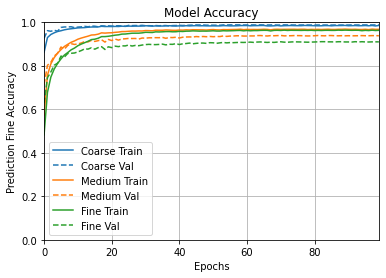

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

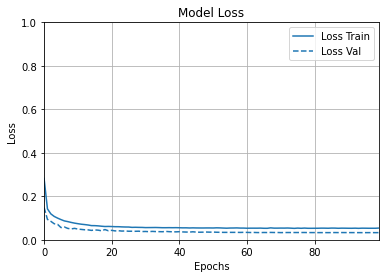

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 16ms/step - loss: 0.0440 - prediction_coarse_loss: 0.0097 - prediction_medium_loss: 0.0457 - prediction_fine_loss: 0.0672 - prediction_coarse_accuracy: 0.9881 - prediction_medium_accuracy: 0.9386 - prediction_fine_accuracy: 0.9103
1. loss ==> 0.04398418962955475
2. prediction_coarse_loss ==> 0.009664753451943398
3. prediction_medium_loss ==> 0.045653123408555984
4. prediction_fine_loss ==> 0.06722350418567657
5. prediction_coarse_accuracy ==> 0.988099992275238
6. prediction_medium_accuracy ==> 0.9386000037193298
7. prediction_fine_accuracy ==> 0.9103000164031982
313/313 [==============================] - 4s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

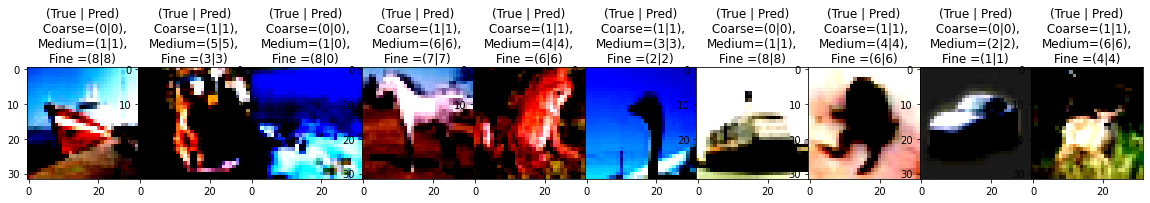

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3951   49]
 [  70 5930]]

  • MEDIUM LEVEL 
[[ 939   18   12   15    1   10    5]
 [  31  940   20    7    0    1    1]
 [   7   11 1975    3    1    3    0]
 [  22    3    4  875   25   43   28]
 [   1    1    3   13  956   23    3]
 [   9    2   10   34   40 1833   72]
 [  11    3    4   28   17   69 1868]]

  • FINE LEVEL 
[[942   5  16   7   0   0   3   3  18   6]
 [  4 971   1   0   0   0   0   0   4  20]
 [ 23   1 880  19  17  21  24   9   3   3]
 [  7   3  24 805  22  89  33  11   2   4]
 [  4   2  18  27 895  19  18  15   2   0]
 [  3   2  14 103  24 829  11  14   0   0]
 [  1   1  13  22   3   3 954   0   1   2]
 [  7   0  10  13  14  11   0 943   0   2]
 [ 33  10   7   1   0   0   0   1 941   7]
 [  3  40   2   2   0   1   1   0   8 943]]

  • Classification Report 


  • COARSE LEVEL 


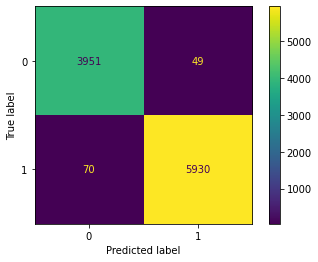

              precision    recall  f1-score   support

           0    0.98259   0.98775   0.98516      4000
           1    0.99180   0.98833   0.99007      6000

    accuracy                        0.98810     10000
   macro avg    0.98720   0.98804   0.98761     10000
weighted avg    0.98812   0.98810   0.98811     10000


  • MEDIUM LEVEL 


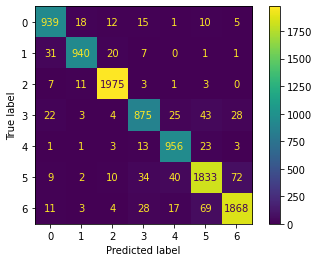

              precision    recall  f1-score   support

           0    0.92059   0.93900   0.92970      1000
           1    0.96115   0.94000   0.95046      1000
           2    0.97387   0.98750   0.98064      2000
           3    0.89744   0.87500   0.88608      1000
           4    0.91923   0.95600   0.93725      1000
           5    0.92482   0.91650   0.92064      2000
           6    0.94487   0.93400   0.93940      2000

    accuracy                        0.93860     10000
   macro avg    0.93457   0.93543   0.93488     10000
weighted avg    0.93855   0.93860   0.93848     10000


  • FINE LEVEL 


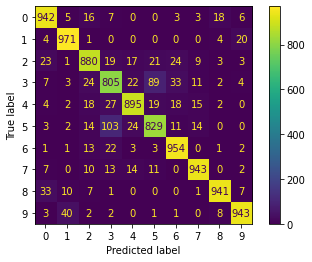

              precision    recall  f1-score   support

           0    0.91723   0.94200   0.92945      1000
           1    0.93816   0.97100   0.95430      1000
           2    0.89340   0.88000   0.88665      1000
           3    0.80581   0.80500   0.80540      1000
           4    0.91795   0.89500   0.90633      1000
           5    0.85200   0.82900   0.84034      1000
           6    0.91379   0.95400   0.93346      1000
           7    0.94679   0.94300   0.94489      1000
           8    0.96118   0.94100   0.95099      1000
           9    0.95542   0.94300   0.94917      1000

    accuracy                        0.91030     10000
   macro avg    0.91017   0.91030   0.91010     10000
weighted avg    0.91017   0.91030   0.91010     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9454783333333333 
Hierarchical Recall = 0.9466 
Hierarchical F1-Score = 0.9459476190476189 
Consistency =  0.9938 
Exact Match =  0.908
